In [4]:
from langgraph.graph import StateGraph,END,START
from typing import TypedDict,Literal
from pydantic import BaseModel,Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

In [5]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [6]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive","negative"] = Field(description="Sentiment of the review")

In [27]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [28]:
strurtured_llm = llm.with_structured_output(SentimentSchema)
strurtured_llm2 = llm.with_structured_output(DiagnosisSchema)

In [9]:
strurtured_llm.invoke("Wow i love the product").sentiment

'positive'

In [47]:
class ReviewSchema(TypedDict):
    review: str
    sentiment: Literal["positive","negative"]
    response: str
    run_diagnosis: dict

In [48]:
def find_sentiment(state: ReviewSchema):

    prompt = f"Give the sentiment of the following review: \n {state["review"]}"
    output = strurtured_llm.invoke(prompt)
    return {"sentiment": output.sentiment}

def checkpoint(state:ReviewSchema)-> Literal["positive_reponse","run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_reponse"
    else:
        return "run_diagnosis"
    
def positive_reponse(state:ReviewSchema):

    prompt = f"""Write a warm thank-you message in response of this review.
    {state["review"]}
and kindly ask to the user to leave a feedback on our website"""
    output = llm.invoke(prompt).content
    return {"response":output}


def run_diagnosis(state: ReviewSchema):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = strurtured_llm2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewSchema):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm.invoke(prompt).content

    return {'response': response}


In [49]:
graph = StateGraph(ReviewSchema)

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_reponse",positive_reponse)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("negative_response",negative_response)

graph.add_edge(START,"find_sentiment")

graph.add_conditional_edges("find_sentiment",checkpoint)
graph.add_edge("positive_reponse",END)


graph.add_edge("find_sentiment","run_diagnosis")
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)

workflow = graph.compile()

In [50]:
initial_state = {"review":"product is good"}
final_state = workflow.invoke(initial_state)
final_state

KeyError: 'diagnosis'

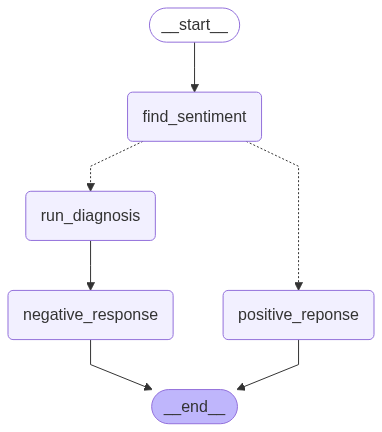

In [ ]:
workflow